# Model

The ultimate goal of the model is to learn a __latent variable space of musical units__. Then, given a musical unit, we wish to encode that unit into a latent vector within the space, and predict the best accompaninment latent vector to that input. Finally, that accompaniment latent vector can be decoded to produce an accompanying musical unit.

This involves many tricky steps, so development will be approached incrementally:

#### 1. Convolutional Autoencoder

Given an input unit of `[num_ticks, num_pitches]`, learn a Convolutional Autoencoder model to generate an encoding of that unit.

```
INPUT -> Convolution layers -> EMBEDDING -> Deconvolution layers -> INPUT
```

Autoencoding: To test this convolutional autoencoder, generate a response to a given input unit using 
- Decoder reconstruction of same input
- Nearest-neighbor unit selection (Similar to what Bretan et al did)

De-noising: Test de-noising abilities of the autoencoder. Given a partial accompaniment input unit, generate a response of
- Decoder reconstruction of "full"/"comp" unit
- Nearest-neighbor unit selection

#### 2. LSTM of latent variables -> Generation using unit selection

Given a sequence of embeddings (from the convolutional autoencoder), predict the next embedding - and perform NN-unit-selection as before, to generate the next unit in the sequence.

#### 3. Convolutional Variational Autoencoder

Learn a new latent space using a VAE architecture. Test how well resconstruction works using
- Decoder reconstruction

#### 4. LSTM of variational latent variables -> Generation using latent space sampling 

Given a sequence of embeddings (from the VAE), predict the next embedding and generate an output musical unit by decoding the predicted embedding!!!


In [1]:
import os, shutil
import random
import sys
import numpy as np
import pypianoroll
from matplotlib import pyplot as plt
import cPickle as pickle
import pianoroll_utils

PICKLE_FILE = './pickle_jar/units_50_songs.pkl'

In [2]:
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, BatchNormalization, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.models import load_model

Using TensorFlow backend.


In [3]:
units = {}
with open(PICKLE_FILE, 'rb') as infile:
    units = pickle.load( infile )

# Print info
print "Loaded", units["input"].shape[0], "units from", PICKLE_FILE
print "input_units.shape: ", units["input"].shape
print "input_units_next.shape: ", units["input_next"].shape
print "comp_units.shape: ", units["comp"].shape
print "comp_units_next.shape: ", units["comp_next"].shape


Loaded 3268 units from ./pickle_jar/units_50_songs.pkl
input_units.shape:  (3268, 96, 128)
input_units_next.shape:  (3268, 96, 128)
comp_units.shape:  (3268, 96, 128)
comp_units_next.shape:  (3268, 96, 128)


In [4]:
# Prepare data
print "Original:", units["input"].shape
NUM_TICKS = units["input"].shape[1] # 96
NUM_PITCHES = units["input"].shape[2] # 128
assert NUM_TICKS == 96 and NUM_PITCHES == 128

# Change from [M, ticks, pitches] to [M, pitches, ticks, channels=1]
input_units = units["input"].swapaxes(1,2).reshape(len(units["input"]), NUM_PITCHES, NUM_TICKS, 1)
comp_units = units["comp"].swapaxes(1,2).reshape(len(units["comp"]), NUM_PITCHES, NUM_TICKS, 1)
# Normalize values between 0 and 1
input_units = input_units.astype('float32') / 127. # 0-127 is the unnormalized velocity range
comp_units = comp_units.astype('float32') / 127. # 0-127 is the unnormalized velocity range
print "Reshaped:", input_units.shape

# Create an array of True (train) and False (test) to split the dataset
train_test_indices = np.random.choice([True, False], size=len(input_units), p=[.9, .1])
# Training data
input_train = input_units[train_test_indices, ...]
comp_train = comp_units[train_test_indices, ...]
# Testing data
input_test = input_units[np.invert(train_test_indices), ...]
comp_test = comp_units[np.invert(train_test_indices), ...]
print "Train:", input_train.shape
print "Test:", input_test.shape


Original: (3268, 96, 128)
Reshaped: (3268, 128, 96, 1)
Train: (2922, 128, 96, 1)
Test: (346, 128, 96, 1)


## 1. Convolutional Autoencoder

Given an input unit of `[num_ticks, num_pitches]`, learn a Convolutional Autoencoder model to generate an encoding of that unit.

```
INPUT -> Convolution layers -> EMBEDDING -> Deconvolution layers -> INPUT
```

### Testing

We will evaluate the autoencoder using two measures:

1. __Autoencoding__: To test this convolutional autoencoder, generate a response to a given input unit using 

    - Decoder reconstruction of same input
    - Nearest-neighbor unit selection (Similar to what Bretan et al did)

2. __De-noising__: Test de-noising abilities of the autoencoder. Given a partial accompaniment input unit, generate a response of

    - Decoder reconstruction of "full"/"comp" unit
    - Nearest-neighbor unit selection

    (inspired by Huang et al Counterpoint by Convolution, and Bretan et al Learning and Evaluating Musical Features with Deep Autoencoders)

These two tests simply require training the model on two different datasets: "full"->"full" for autoencoding, and "input"->"comp" for de-noising.

### Architecture


_Initial code adapted from the [Keras tutorial on autoencoders](https://blog.keras.io/building-autoencoders-in-keras.html)._

_Inspiration for convolution autoencoder network from "Learning and Evaluating Musical Features with Deep
Autoencoders"._


# Autoencoder V0

`code given below`

### Details

Based on "Learning and Evaluating Musical Features with Deep Autoencoders", but adapted for different input size.

```
Data: -
Embedding shape: (None, 1, 1, 800) -> 800 elements
Epochs: -
Batch size: -
Final loss: -
```

### Notes

Pretty sophisticated model, but unfortunately not able to train due to a `ResourceExhaustedError` upon running `model.fit`. This is most likely due to insufficient GPU memory (model is very large).

Several attempts were made to shrink the model / reduce batch size (which apparently helps), but was not able to shake the error.

### Next steps
1. Look at how to shrink this model / use an alternative model. This [SO thread](https://stackoverflow.com/questions/41526071/why-is-keras-throwing-a-resourceexhaustederror) may be helpful.

In [45]:

input_mat = Input(shape=(NUM_PITCHES, NUM_TICKS, 1))  # 'channels_last' data format (only 1 channel in our case)

## ENCODER

# First four layers are Conv2D
x = Conv2D(100, (13, 21), strides=(5,5), activation='relu', padding='valid')(input_mat)
x = BatchNormalization(axis=3)(x)
x = Conv2D(200, (2, 7), strides=(2,3), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2D(400, (2, 2), strides=(2,2), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2D(800, (2, 2), strides=(2,1), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
# Following three are fully connected
x = Conv2D(800, (3, 1), strides=(1,1), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
x = Dense(400, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(100, activation='relu')(x)
encoded = BatchNormalization()(x)

# at this point the representation is a 100-dimensional vector

## DECODER

# Two fully connected
decoded = Dense(400, activation='relu')(encoded)
x = BatchNormalization()(x)
x = Conv2DTranspose(800, (3, 1), strides=(1,1), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
# Deconvolution / Convolution Transpose layers
x = Conv2DTranspose(800, (2, 2), strides=(2,1), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2DTranspose(400, (2, 2), strides=(2,2), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2DTranspose(200, (2, 7), strides=(2,3), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2DTranspose(100, (13, 21), strides=(5,5), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2DTranspose(1, (NUM_TICKS, NUM_PITCHES), activation='relu', padding='valid')(x)
decoded = BatchNormalization(axis=3)(x)

autoencoder = Model(input_mat, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [39]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 128, 96, 1)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 24, 16, 100)       27400     
_________________________________________________________________
batch_normalization_85 (Batc (None, 24, 16, 100)       400       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 12, 4, 200)        280200    
_________________________________________________________________
batch_normalization_86 (Batc (None, 12, 4, 200)        800       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 6, 2, 400)         320400    
_________________________________________________________________
batch_normalization_87 (Batc (None, 6, 2, 400)         1600      
__________

In [ ]:
# Train model model
autoencoder.fit(input_train, input_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(input_test, input_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])
# Run `tensorboard --logdir=/tmp/autoencoder` to start tensorboard

Train on 2929 samples, validate on 339 samples
Epoch 1/100
 256/2929 [=>............................] - ETA: 1:00 - loss: 0.6844

# Autoencoder V1

`code given below`

### Details

Pretty arbitrary variant of the convolutional autoencoder architecture suggested in the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html).

```
Data: input->input
Embedding shape: (None, 32, 24, 32) -> 24576 elements
Epochs: 100
Batch size: 32
Final loss: [loss: -0.0047 - val_loss: -0.0052]
```

### Notes
~~Final binary crossentropy loss (after 100 epochs) gives `loss: -0.0047 - val_loss: -0.0052`, which is strange since __I don't think binary crossentropy should give negative values__? Will have to investigate further.~~ 

Besides that, the decoded output looks really good. The graphs and playback are almost indistinguishable - can notice what appears to be quantization effects in the graphs, and some difference (note drops/additions, incorrect pitch) is occasionally audible. But mostly similar. 

On the whole, this model was a successful "trial" model. Demonstrates that the autoencoder actually produces a valid pianoroll, but our __input size was 12288 and embedding size is 24576__, which actually enlarges the dimensionality instead of shrinking it.

### Next steps
1. ~~Investigate negative loss values ([most likely](https://github.com/Lasagne/Recipes/issues/54) due to some normalization issue)~~ (Fixed with correct normalization of data in data_prep)
2. Train on input->comp, or input->comp_next
3. Shrink the embedding layer!! 

In [5]:

input_mat = Input(shape=(NUM_PITCHES, NUM_TICKS, 1))  # 'channels_last' data format (only 1 channel in our case)

# ENCODER
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_mat)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# At this point, the data is already represented in the embedding

# DECODER
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_mat, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [6]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 96, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 96, 32)       320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 24, 32)        9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 64, 48, 32)        0         
__________

In [7]:
# Train model model
autoencoder.fit(input_train, input_train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(input_test, input_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

MODEL_AUTOENCODER_V1_FILE = './models/autoencoder_v1.h5'
autoencoder.save(MODEL_AUTOENCODER_V1_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_AUTOENCODER_V1_FILE

Train on 2942 samples, validate on 326 samples
Epoch 1/100
2942/2942 [==============================] - 35s 12ms/step - loss: 0.2273 - val_loss: 0.1643
Epoch 2/100
2942/2942 [==============================] - 28s 9ms/step - loss: 0.1640 - val_loss: 0.1642
Epoch 3/100
2942/2942 [==============================] - 30s 10ms/step - loss: 0.1177 - val_loss: 0.0276
Epoch 4/100
2942/2942 [==============================] - 30s 10ms/step - loss: 0.0235 - val_loss: 0.0197
Epoch 5/100
2942/2942 [==============================] - 29s 10ms/step - loss: 0.0163 - val_loss: 0.0128
Epoch 6/100
2942/2942 [==============================] - 29s 10ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 7/100
2942/2942 [==============================] - 29s 10ms/step - loss: 0.0098 - val_loss: 0.0093
Epoch 8/100
2942/2942 [==============================] - 29s 10ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 9/100
2942/2942 [==============================] - 29s 10ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 10/

Epoch 78/100
2942/2942 [==============================] - 28s 10ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 79/100
2942/2942 [==============================] - 28s 10ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 80/100
2942/2942 [==============================] - 28s 10ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 81/100
2942/2942 [==============================] - 28s 10ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 82/100
2942/2942 [==============================] - 28s 10ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 83/100
2942/2942 [==============================] - 28s 10ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 84/100
2942/2942 [==============================] - 29s 10ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 85/100
2942/2942 [==============================] - 28s 10ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 86/100
2942/2942 [==============================] - 28s 10ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 87/100
2942/2942 [======================

In [8]:
autoencoder = load_model(MODEL_AUTOENCODER_V1_FILE)

In [9]:
# Run test inputs through the autoencoder
decoded_test = autoencoder.predict(input_test)

(96, 128)
(96, 128)


0

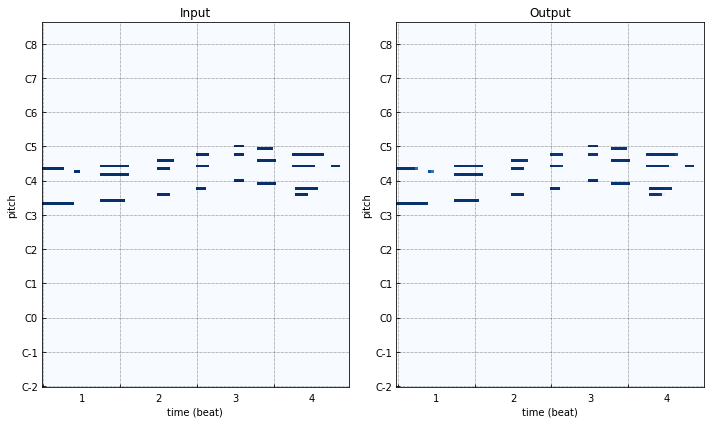

In [13]:
# Inspect a random input-output sample
sample_index = np.random.randint(len(input_test))
sample_input = input_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
sample_output = decoded_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127

print(sample_input.shape)
print(sample_output.shape)

# Plot comparison
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Output')
pypianoroll.plot_pianoroll(ax[0], sample_input, beat_resolution=24)
pypianoroll.plot_pianoroll(ax[1], sample_output, beat_resolution=24)
fig.tight_layout()

# Play comparison
pianoroll_utils.playPianoroll(sample_input)
pianoroll_utils.playPianoroll(sample_output)


# Autoencoder V2

`code given below`

### Details

Iterating on the faults of the previous model: 
1. Change from an `input->input` autoencoder to a `input->comp` de-noising autoencoder,
2. Reduce size of embedding layer by increasing number of conv/pooling layers.

```
Data: input->comp, input->input
Embedding shape: (None, 3, 2, 100) -> 600 elements
Epochs: 50
Batch size: 128
Final loss: [loss: 0.0322 - val_loss: 0.0334]
```

### Notes

#### Test \#1
`input->comp`

This test was an absolute disaster! The output produced _actually_ sounded like someone dropping a piano off a cliff (which is fun but not very useful for the purpose of this project).

Interesting things to note - the training and validation loss started at `loss: 0.0375 - val_loss: 0.0302`, then ended at `[loss: 0.0322 - val_loss: 0.0334]`, barely learning anything at all. The model seemed to be improving consistently at the beginning, reaching a loss of about `0.02` at the halfway point (25th epoch), but then started getting worse consistently. Why did this happen? I thought that GD should only ever improve the model (or in the case of BGD, deteriorate slightly but improve overall). Also, what I hear is clearly not only 2% error. Maybe need to re-evaluate the loss function.

One other thing about the model, is that perhaps it is too much to expect it to be able to predict the left and right accompaniments. Might be worth trying `input->full` instead of `input->comp`, and maybe think of a completely new way to structure the data...

Finally, the model itself was also changed significantly from the previous version. Maybe the drop in hidden layer dimension is too steep, or the embedding size is too small. Should test with basic `input->input` case first.

#### Test \#2
`input->input`

Hmm, interestingly this wasn't any better than the input->comp instance. Which implies that the model itself is broken. Onwards!

### Next steps
1. Investigate output (why doesn't the pianoroll plot look like a piano being thrown off a cliff?)
2. Investigate behaviour of the trainig/validation losses.
3. ~~Try using `input-input` and `input-full` to make sure the model can actually something useful.~~ Even the "trivial" `input->input` case failed, which means that the model isn't able to represent the info sufficiently.

In [6]:

input_mat = Input(shape=(NUM_PITCHES, NUM_TICKS, 1))  # 'channels_last' data format (only 1 channel in our case)

# ENCODER
x = Conv2D(200, (13, 21), strides=(5,5), activation='relu', padding='valid')(input_mat)
x = BatchNormalization()(x)

x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# At this point, the data is already represented in the embedding

# DECODER
x = Conv2D(100, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(200, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2DTranspose(1, (13, 21), strides=(5,5), activation='relu', padding='valid')(x)

autoencoder = Model(input_mat, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [7]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 96, 1)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 16, 200)       54800     
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 16, 200)       800       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 16, 100)       180100    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 8, 100)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 8, 100)        90100     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 4, 100)         0         
__________

In [7]:
# Train model [INPUT->COMP]
autoencoder.fit(input_train, comp_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(input_test, comp_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

MODEL_AUTOENCODER_V2_FILE = './models/autoencoder_v2.h5'
autoencoder.save(MODEL_AUTOENCODER_V2_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_AUTOENCODER_V2_FILE

Train on 2924 samples, validate on 344 samples
Epoch 1/50
2924/2924 [==============================] - 21s 7ms/step - loss: 0.0375 - val_loss: 0.0302
Epoch 2/50
2924/2924 [==============================] - 15s 5ms/step - loss: 0.0273 - val_loss: 0.0265
Epoch 3/50
2924/2924 [==============================] - 15s 5ms/step - loss: 0.0250 - val_loss: 0.0252
Epoch 4/50
2924/2924 [==============================] - 14s 5ms/step - loss: 0.0241 - val_loss: 0.0247
Epoch 5/50
2924/2924 [==============================] - 14s 5ms/step - loss: 0.0242 - val_loss: 0.0255
Epoch 6/50
2924/2924 [==============================] - 14s 5ms/step - loss: 0.0243 - val_loss: 0.0246
Epoch 7/50
2924/2924 [==============================] - 14s 5ms/step - loss: 0.0236 - val_loss: 0.0241
Epoch 8/50
2924/2924 [==============================] - 15s 5ms/step - loss: 0.0233 - val_loss: 0.0242
Epoch 9/50
2924/2924 [==============================] - 14s 5ms/step - loss: 0.0239 - val_loss: 0.0255
Epoch 10/50
2924/2924 [===

In [8]:
# Train model [INPUT->INPUT]
autoencoder.fit(input_train, input_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(input_test, input_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

MODEL_AUTOENCODER_V2_FILE = './models/autoencoder_v2_input_input.h5'
autoencoder.save(MODEL_AUTOENCODER_V2_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_AUTOENCODER_V2_FILE

Train on 2922 samples, validate on 346 samples
Epoch 1/50
2922/2922 [==============================] - 21s 7ms/step - loss: 0.0529 - val_loss: 0.0385
Epoch 2/50
2922/2922 [==============================] - 14s 5ms/step - loss: 0.0388 - val_loss: 0.0374
Epoch 3/50
2922/2922 [==============================] - 14s 5ms/step - loss: 0.0372 - val_loss: 0.0365
Epoch 4/50
2922/2922 [==============================] - 14s 5ms/step - loss: 0.0348 - val_loss: 0.0344
Epoch 5/50
2922/2922 [==============================] - 13s 5ms/step - loss: 0.0330 - val_loss: 0.0334
Epoch 6/50
2922/2922 [==============================] - 14s 5ms/step - loss: 0.0366 - val_loss: 0.0395
Epoch 7/50
2922/2922 [==============================] - 13s 5ms/step - loss: 0.0338 - val_loss: 0.0324
Epoch 8/50
2922/2922 [==============================] - 15s 5ms/step - loss: 0.0366 - val_loss: 0.0428
Epoch 9/50
2922/2922 [==============================] - 14s 5ms/step - loss: 0.0361 - val_loss: 0.0367
Epoch 10/50
2922/2922 [===

In [9]:
autoencoder = load_model(MODEL_AUTOENCODER_V2_FILE)

In [10]:
# Run test inputs through the autoencoder
decoded_test = autoencoder.predict(input_test)

(96, 128)
(96, 128)


0

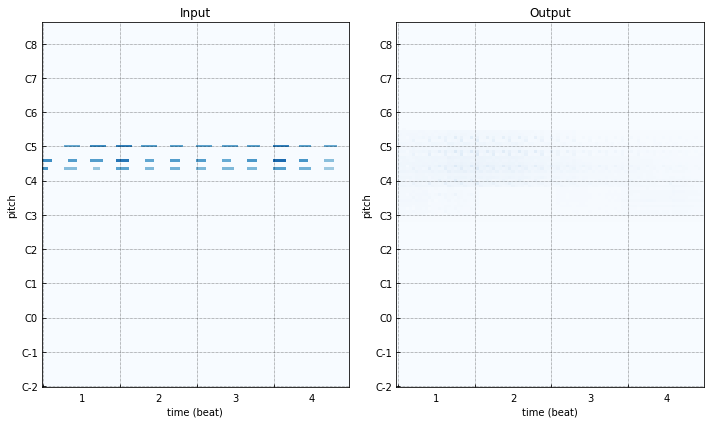

In [13]:
# Inspect a random input-output sample
sample_index = np.random.randint(len(input_test))
sample_input = input_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
# sample_comp = comp_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
sample_output = decoded_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127

print(sample_input.shape)
# print(sample_comp.shape)
print(sample_output.shape)

# Plot comparison
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
# ax[1].set_title('Target')
ax[1].set_title('Output')
pypianoroll.plot_pianoroll(ax[0], sample_input, beat_resolution=24)
# pypianoroll.plot_pianoroll(ax[1], sample_comp, beat_resolution=24)
pypianoroll.plot_pianoroll(ax[1], sample_output, beat_resolution=24)
fig.tight_layout()

# Play comparison
pianoroll_utils.playPianoroll(sample_input)
# pianoroll_utils.playPianoroll(sample_comp)
pianoroll_utils.playPianoroll(sample_output)
